In [1]:
# 导入必要的包
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from keras import backend as K
# import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


heatmap.shape: (7, 7)


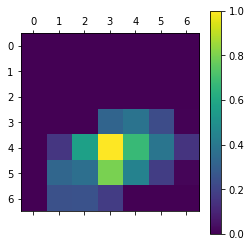

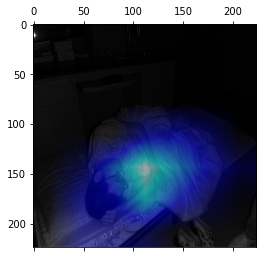

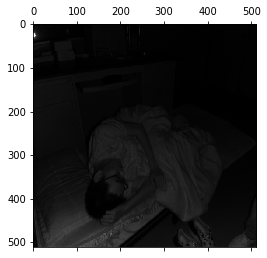

In [21]:
imagePath_test = "./test/14.jpg"
# 导入模型
model_my = tf.keras.models.load_model('./模型保存/sleep_ResNet50')
# 读取测试图像并使其添加到神经网络预测的输入管道
image_pre = cv2.imread(imagePath_test)
image_pre = cv2.cvtColor(image_pre, cv2.COLOR_BGR2RGB)
image_pre = cv2.resize(image_pre, (224, 224))
image_pre = image_pre.reshape(1,224,224,3).astype('float32')
x = image_pre/255
#x = (image_pre - 127.5) / 127.5
result = model_my.predict(x)

# 应用Grad-CAM算法，展示图象哪些部分最像新冠肺炎
covid_output = model_my.output[:,np.argmax(result[0])] # 提取预测向量中的“新冠肺炎”元素
last_conv_layer = model_my.get_layer('conv5_block3_3_conv') # block5_conv3层的输出特征图，它是VGG16的最后一个卷积层
grads = K.gradients(covid_output,last_conv_layer.output)[0] # "新冠肺炎"类别相对于block5_conv3输出特征图的梯度
pooled_grads = K.mean(grads,axis=(0,1,2)) # 形状为(512,)的向量，每个元素是特定特征图通道的梯度平均大小
iterate = K.function([model_my.input],[pooled_grads,last_conv_layer.output[0]]) # 访问刚刚定义的量：对于给定的样本图像，pooled_grads和block5_conv3层的输出特征图
pooled_grads_value, conv_layer_output_value = iterate([x]) # 对于样本图像，这两个量都是Numpy数组
for i in range(2048):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1) # 得到的特征图的逐同到平均值即为类激活的热力图
# 为了便于可视化，我们还需要将热力图标准化到[0,1]范围内。
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
print('heatmap.shape:',heatmap.shape)
plt.matshow(heatmap) # 提取到的特征区域可视化，等下转换成和原图像大小相同以及RGB图像后，再乘以系数叠加
plt.colorbar()

# 最后，将热力图与原始图像叠加
image_pre_src = cv2.imread(imagePath_test)
image_pre = cv2.imread(imagePath_test)
image_pre = cv2.cvtColor(image_pre, cv2.COLOR_BGR2RGB)
image_pre = cv2.resize(image_pre, (224, 224))
#image_pre = (image_pre - 127.5) / 127.5
image_pre = image_pre/255.0

heatmap = cv2.resize(heatmap,(image_pre.shape[1],image_pre.shape[0])) # 将热力图的大小调整为与原始图像相同
heatmap = np.uint8(255*heatmap) # 将热力图转换为RGB格式
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_HOT) # 将热力图叠加到原始图像
suerimposed_img = heatmap*0.002+ image_pre # 这里的0.005是热力图强度因子
plt.matshow(suerimposed_img) # 显示图像
plt.savefig("./特征可视化/ir_14")
#plt.colorbar()
plt.matshow(image_pre_src) # 显示原图比对